In [3]:
!pip install torch_geometric

In [4]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0


In [5]:
import os
import torch
import matplotlib.pyplot as plt

from torch_geometric.nn import GCNConv
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
import torch_geometric.transforms as T

transform = T.Compose([T.GCNNorm(), T.NormalizeFeatures()])

dataset = TUDataset(root="data/MUTAG", name="MUTAG", transform=None)
print(dataset)
data = dataset[0]
print(data)

MUTAG(188)
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [6]:
print(f'Number of classes: {dataset.num_classes}')

Number of classes: 2


In [7]:
import numpy as np
torch.manual_seed(12345)
dataset = dataset.shuffle()

split = int(0.8 * len(dataset))
train_dataset, test_dataset = dataset[:split], dataset[split:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [8]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



In [9]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [10]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 31):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 007, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 008, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 009, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 011, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 012, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 013, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 014, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 015, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 016, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 017, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 018, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 019, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 020, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 021, Train Acc: 0.6467, Test Acc:

In [11]:
for data in test_loader:
  out = model(data.x, data.edge_index, data.batch) 
  print(F.softmax(out[0], dim=0)[0] > 2) 
  pred = out.argmax(dim=1) 
  print(pred[0].item()) 
  print(len(pred))
  break

tensor(False)
1
38


In [12]:
import os.path as osp
from re import sub
from sklearn import neighbors
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import copy
import torch_geometric.transforms as T
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import GCNConv, GNNExplainer
from torch import Tensor
from torch_geometric.loader import DataLoader

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import subgraph
import numpy as np

import networkx as nx
from torch_geometric import utils


def expand(starts, ends, target, max_depth=1, prev=[]):
    node_neighbors = np.array([ends[idx] for idx, node in enumerate(starts) if node == target and ends[idx] != target])
    prev.append(target)
    if max_depth > 1:
        for n in node_neighbors:
            node_neighbors = np.concatenate((node_neighbors, expand(starts, ends, target=n, max_depth=max_depth-1, prev=prev)), axis=0)
    indices = np.unique(node_neighbors, return_index=True)[1]
    return np.array([node_neighbors[i] for i in sorted(indices)])

def mysubgraph(data, subset):
    out = subgraph(subset, data.edge_index, relabel_nodes=False,
                   num_nodes=data.num_nodes, return_edge_mask=True)
    edge_index, _, edge_mask = out
    out2 = subgraph(subset, data.edge_index, relabel_nodes=True,
                   num_nodes=data.num_nodes, return_edge_mask=True)
    train_index, _, _ = out2
    if subset.dtype == torch.bool:
        num_nodes = int(subset.sum())
    else:
        num_nodes = subset.size(0) 
    _data = copy.copy(data)
    # _data.train_index = train_index
    for key, value in _data:
        if key == 'edge_index':
            _data.edge_index = edge_index
        elif key == 'num_nodes':
            _data.num_nodes = num_nodes
        elif isinstance(value, Tensor):
            if data.is_node_attr(key):
                _data[key] = value[subset]
            elif data.is_edge_attr(key):
                _data[key] = value[edge_mask]
    _data.train_index = train_index
    return _data

def my_to_networkx(data, node_attrs=None, edge_attrs=None,
                to_undirected = False,
                remove_self_loops: bool = False):
    import networkx as nx

    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()

    G.add_nodes_from(list(set(data.edge_index[0].numpy())))
    node_attrs, edge_attrs = node_attrs or [], edge_attrs or []

    values = {}
    for key, value in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(value):
            value = value if value.dim() <= 1 else value.squeeze(-1)
            values[key] = value.tolist()
        else:
            values[key] = value

    to_undirected = "upper" if to_undirected is True else to_undirected
    to_undirected_upper = True if to_undirected == "upper" else False
    to_undirected_lower = True if to_undirected == "lower" else False

    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        
        if to_undirected_upper and u > v:
            continue
        elif to_undirected_lower and u < v:
            continue
        if remove_self_loops and u == v:
            continue
        G.add_edge(u, v)

        for key in edge_attrs:
            G[u][v][key] = values[key][i]
    for key in node_attrs:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})
    return G

def process_one_graph(data):
    used = []
    num_nodes = data.x.shape[0]
    subgraph_sizes = [max(int(num_nodes/4), 5)]
    start_nodes, end_nodes = np.array(data.edge_index)
    sub_graphs = []
    # make a grow from each node
    for target_idx in range(num_nodes):
        nodes_to_keep = expand(starts=start_nodes, ends=end_nodes, target=target_idx, max_depth=3, prev=[target_idx])
        if nodes_to_keep.shape[0] == 0:
            continue
        for size in subgraph_sizes:
            # select the grows based on size
            _subset = nodes_to_keep[:size]
            # remove repetitive stuff
            if set(_subset) in used:
                continue
            else:
                used.append(set(_subset))
            _subset = torch.from_numpy(np.array(_subset))
            sub_graphs.append((target_idx, mysubgraph(data=data, subset=_subset)))
    return sub_graphs

In [13]:

pred_list = []
all_graphs = []
all_subgraphs = []
confidences = []
for idx, data in enumerate(tqdm.tqdm(dataset)):
    out = model(data.x, data.edge_index, data.batch)  
    out = out.softmax(dim=1)
    pred = out.argmax(dim=1)
    pred_list.append(pred)
    all_graphs.append(data)

    subgraphs = process_one_graph(data)
    all_subgraphs.append(subgraphs)
    confidences.append(out[0, pred].item())


# for target_idx, graph in tqdm.tqdm(all_subgraphs):
#     # nx.draw_networkx(utils.to_networkx(graph, remove_self_loops=True))
#     # plt.show()


100%|██████████| 188/188 [00:01<00:00, 140.42it/s]


<class 'list'>
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


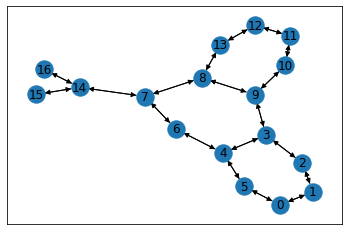

In [14]:
print(type(all_graphs))
for data in all_graphs:
  print(data)
  nx.draw_networkx(utils.to_networkx(data, remove_self_loops=True))
  plt.show()
  break

<class 'list'>
(0, Data(edge_index=[2, 8], x=[5, 7], edge_attr=[8, 4], y=[1], train_index=[2, 8]))


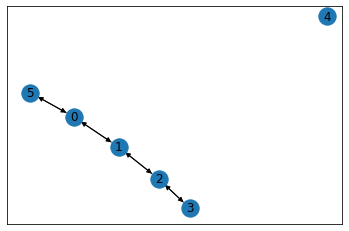

In [15]:
print(type(all_subgraphs))
for data in all_subgraphs:
  for subgraph in data:
    print(subgraph)
    nx.draw_networkx(utils.to_networkx(subgraph[1], remove_self_loops=True))
    plt.show()
    break
  break



In [16]:
print(type(test_dataset))
for test_data in test_dataset:
  print(test_data)
  
  break

<class 'torch_geometric.datasets.tu_dataset.TUDataset'>
Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1])


In [17]:
min_sufficient_explanation = [] #list of lists, each inner list correspond to one full graph in TUDataset Protein,
#containing each full graph's MSE's

for idx, data_collection in enumerate(tqdm.tqdm(all_subgraphs)):
  sub_mse = [] #sub_mse for this collection, correspond to one original full graph
  sub_confidence = []
  for data in data_collection:
    out = model(data[1].x, data[1].train_index, data[1].batch)

    out = out.softmax(dim=1)
    pred = out.argmax(dim=1)
    
      
    # if the subgraph's predicted label matches the original full graph's predicted, add to its min_suff_expl list
    if torch.eq(pred, pred_list[idx]).item():
      sub_mse.append(data[1])
      sub_confidence.append(abs((out[0, pred]).item() - confidences[idx]))
  

  sort_indices = np.argsort(sub_confidence)
  sorted_mse = [sub_mse[i] for i in sort_indices]
  min_sufficient_explanation.append(sorted_mse)

  

100%|██████████| 188/188 [00:02<00:00, 84.35it/s]


For Graph 0, with prediction 1:


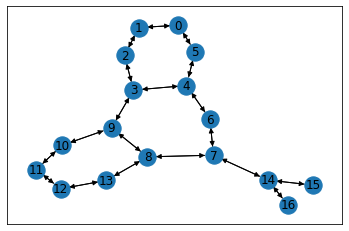

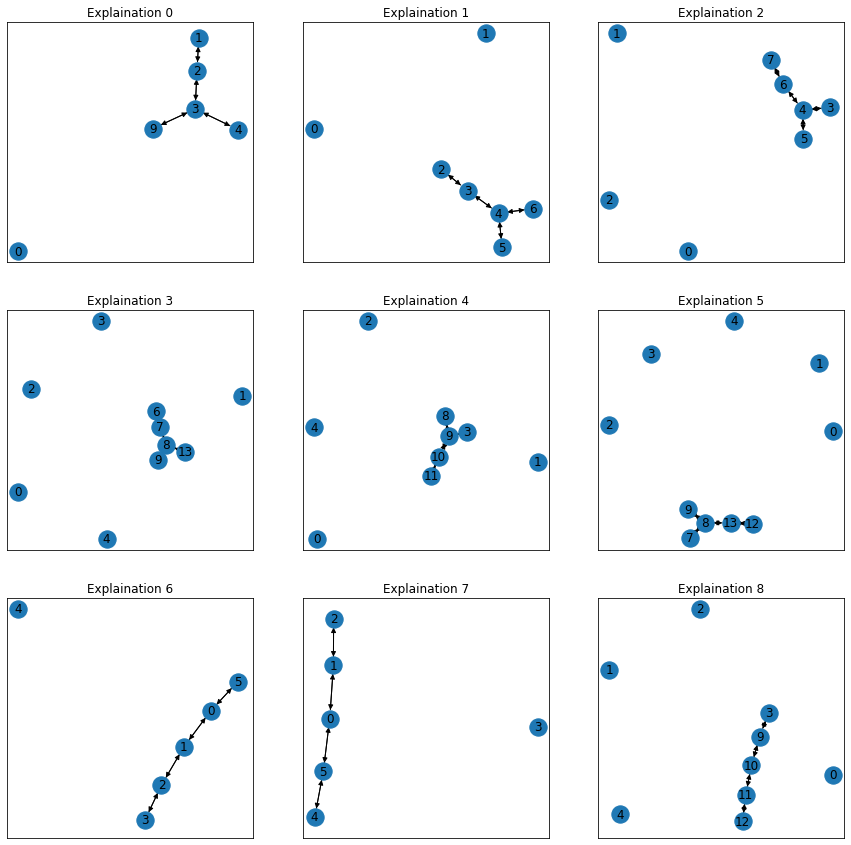

In [18]:
for i, graph in enumerate(all_graphs):
    prediction = pred_list[i].item()
    confidence = confidences[i]
    subgraph_explain = min_sufficient_explanation[i]
    print("For Graph {}, with prediction {}:".format(i, prediction))
    nx.draw_networkx(utils.to_networkx(graph, remove_self_loops=True))
    plt.show()

    fig, axes = plt.subplots(nrows=3, ncols=3)
    fig.set_size_inches(15, 15)
    ax = axes.flatten()
    for j in range(9):
        nx.draw_networkx(utils.to_networkx(subgraph_explain[j], remove_self_loops=True), ax=ax[j])
        ax[j].set_title("Explaination {}".format(j))
    plt.show()
    break

Explain graph: 100%|██████████| 200/200 [00:00<00:00, 492.06it/s]


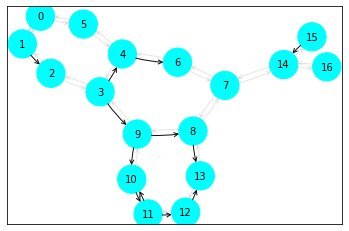

In [19]:
explainer = GNNExplainer(model, epochs=200, return_type='log_prob')
node_feat_mask, edge_mask = explainer.explain_graph(all_graphs[0].x, all_graphs[0].edge_index)
ax, G = explainer.visualize_subgraph(None, edge_index = all_graphs[0].edge_index, edge_mask = edge_mask, y =  all_graphs[0].y)

In [20]:
#input: 
# pred_list: [tensor, tensor, tensor ...], len = len(TUDataset/Protein)
#   each element is a one-element tensor 
#   representing the predicted label of one graph in TUDataset/Protein
# all_subgraph: [[subgraph, subgraph..], [subgraph, subgraph..]...], len = len(TUDataset/Protein)
#   each element is a list of subgraphs obtained from one graph in TUDataset/Protein
#   each subgraph is a tuple in the form (k, Data(edge_index=[2, 24], x=[8, 0], y=[1]))
#   where k is the index of the node that this subgraph expanded from
#output:
# min_sufficient_explanation: [[subgraph, subgraph,..], [subgraph, subgraph]...]
#   len = len(TUDataset/Protein)
#   each element is a list of subgraphs which are the MSEs
#   each subgraph is a tuple in the form (k, Data(edge_index=[2, 24], x=[8, 0], y=[1]))
#   where k is the index of the node that this subgraph expanded from